In [1]:
# Copyright 2022 Google LLC.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

`jax.experimental.pjit` example using JAXopt.
=========================================
The purpose of this example is to illustrate how JAXopt solvers can be easily
used for distributed training thanks to `jax.experimental.pjit`. In this case, we begin by
implementing data parallel training of a multi-class logistic regression model
on synthetic data.

**NOTE: `jax.experimental.pjit` is not yet supported on Google Colab. Please connect to Google Cloud TPUs to execute the example.**

In [2]:
#@markdown The number of optimization steps to perform:
MAXITER = 100  #@param{type:"integer"}
#@markdown The number of samples in the (synthetic) dataset:
NUM_SAMPLES = 50000  #@param{type:"integer"}
#@markdown The number of features in the (synthetic) dataset:
NUM_FEATURES = 784  #@param{type:"integer"}
#@markdown The number of classes in the (synthetic) dataset:
NUM_CLASSES = 10  #@param{type:"integer"}
#@markdown The stepsize for the optimizer (set to 0.0 to use line search):
STEPSIZE = 0.0  #@param{type:"number"}
#@markdown The line search approach (either `'zoom'` or `backtracking`), ignored if `STEPSIZE > 0.0`:
LINESEARCH = 'zoom'  #@param{type:"string"}

# Imports and TPU setup

In [3]:
%%capture
%pip install jaxopt

In [4]:
import time
from typing import Any, Callable, Tuple, Union

# activate TPUs if available
try:
    import jax.tools.colab_tpu
    jax.tools.colab_tpu.setup_tpu()
except KeyError:
    print("TPU not found, continuing without it.")

import jax
import jax.numpy as jnp

import jaxopt

import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets

In [5]:
jax.local_devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

# Type aliases

In [6]:
Array = Union[np.ndarray, jax.Array]

# Auxiliary functions
A minimal working example of how to create a `Mesh` for data parallel execution using `pjit`. Please note that, as opposed to `pmap`, `pjit` allows to seemlessly combine data and model parallel execution as well.

In [7]:
from jax.sharding import Mesh
from jax.sharding import PartitionSpec
from jax.experimental.pjit import pjit


def setup_data_parallel_mesh():
  global_mesh = Mesh(np.asarray(jax.devices(), dtype=object), ['data'])
  jax.experimental.maps.thread_resources.env = (
      jax.experimental.maps.ResourceEnv(physical_mesh=global_mesh, loops=()))
  
setup_data_parallel_mesh()

# Custom-loop
The following code uses data-parallelism in the train loop. Through the `use_pjit` keyword argument we can deactivate this parallelism. We'll use this feature later to benchmark the impact of parallelism.

In [8]:
def fit(
    data: Tuple[Array, Array],
    init_params: Array,
    stepsize: float = 0.0,
    linesearch: str = 'zoom',
    use_pjit: bool = False,
) -> Tuple[np.ndarray, np.ndarray, float]:
  """Fits a multi-class logistic regression model for demonstration purposes.

  Args:
    data: A tuple `(X, y)` with the training covariates and categorical labels,
      respectively.
    init_params: The initial value of the model's weights.
    stepsize: The stepsize to use for the solver. If set to `0`, linesearch will
      be used instead.
    linesearch: The linesearch algorithm to use. If `stepsize > 0`, linsearch
      will be disabled.
    use_pjit: Whether to distribute the computation across replicas or use only
      the first device available.

  Returns:
    The per-step errors and runtimes, as well as the JIT-compile time for the
    solver's `update` function.
  """
  # When using `pjit` to distribute the computation across devices, it is not
  # necessary to override the `value_and_grad` of `fun` (though it is supported
  # if desired for other reasons, e.g. gradient clipping).
  solver = jaxopt.LBFGS(fun=jaxopt.objective.multiclass_logreg,
                        stepsize=stepsize,
                        linesearch=linesearch)
  # Apply the `jax.pmap` transform to the function to be computed in a
  # distributed manner (the solver's `update` method in this case). Otherwise,
  # we JIT compile it.
  if use_pjit:
    update = pjit(
      solver.update,
      in_axis_resources=(None, None, PartitionSpec('data')),
      out_axis_resources=None)
  else:
    update = jax.jit(solver.update)

  # Initialize solver state.
  state = solver.init_state(init_params, data=data)
  params = init_params
  # When using `pjit` for data-parallel training, we do not need to explicitly
  # replicate model parameters across devices. Instead, replication is specified
  # via the `in_axes_resources` argument of the `pjit` transformation.

  # Finally, since in this demo we are *not* using mini-batches, it pays off to
  # transfer data to the device beforehand. Otherwise, host-to-device transfers
  # occur in each update. This is true regardless of whether we use distributed
  # or single-device computation.
  if use_pjit:  # Shards data and moves it to device,
    data = pjit(
      lambda X, y: (X, y),
      in_axis_resources=PartitionSpec('data'),
      out_axis_resources=PartitionSpec('data'))(*data)
  else:  # Just move data to device.
    data = jax.tree_map(jax.device_put, data)

  # Pre-compiles update, preventing it from affecting step times.
  tic = time.time()
  _ = update(params, state, data)
  compile_time = time.time() - tic

  outer_tic = time.time()

  step_times = np.zeros(MAXITER)
  errors = np.zeros(MAXITER)
  for it in range(MAXITER):
    tic = time.time()
    params, state = update(params, state, data)
    jax.tree_map(lambda t: t.block_until_ready(), (params, state))
    step_times[it] = time.time() - tic
    errors[it] = state.error.item()

  print(
      f'Total time elapsed with {linesearch} linesearch and pjit = {use_pjit}:',
      round(time.time() - outer_tic, 2), 'seconds.')

  return errors, step_times, compile_time

# Boilerplate
Creates dataset, calls `fit` with and without `jax.pjit`, makes figures.

In [9]:
def run():
  """Boilerplate to run the demo experiment."""
  data = datasets.make_classification(n_samples=NUM_SAMPLES,
                                      n_features=NUM_FEATURES,
                                      n_classes=NUM_CLASSES,
                                      n_informative=50,
                                      random_state=0)
  init_params = jnp.zeros([NUM_FEATURES, NUM_CLASSES])

  errors, step_times, compile_time = {}, {}, {}

  for use_pjit in (True, False):
    exp_name: str = f"{'with' if use_pjit else 'without'}_pjit"
    _errors, _step_times, _compile_time = fit(data=data,
                                              init_params=init_params,
                                              stepsize=STEPSIZE,
                                              linesearch=LINESEARCH,
                                              use_pjit=use_pjit)
    errors[exp_name] = _errors
    step_times[exp_name] = _step_times
    compile_time[exp_name] = _compile_time

  plt.figure(figsize=(10, 6.18))
  for use_pjit in (True, False):
    exp_name: str = f"{'with' if use_pjit else 'without'}_pjit"
    plt.plot(jnp.arange(MAXITER), errors[exp_name], label=exp_name)
  plt.xlabel('Iterations', fontsize=16)
  plt.ylabel('Gradient error', fontsize=16)
  plt.yscale('log')
  plt.legend(loc='best', fontsize=16)
  plt.title(f'NUM_SAMPLES = {NUM_SAMPLES}, NUM_FEATURES = {NUM_FEATURES}',
            fontsize=22)

  plt.figure(figsize=(10, 6.18))
  for use_pjit in (True, False):
    exp_name: str = f"{'with' if use_pjit else 'without'}_pjit"
    plt.plot(jnp.arange(MAXITER), step_times[exp_name], label=exp_name)
  plt.xlabel('Iterations', fontsize=16)
  plt.ylabel('Step time', fontsize=16)
  plt.legend(loc='best', fontsize=16)
  plt.title(f'NUM_SAMPLES = {NUM_SAMPLES}, NUM_FEATURES = {NUM_FEATURES}',
            fontsize=22)

  return errors, step_times, compile_time

# Main

num_samples: 50000
num_features: 784
num_features: 10
maxiter: 100
stepsize: 0.0
linesearch (ignored if `stepsize` > 0): zoom

Total time elapsed with zoom linesearch and pjit = True: 3.79 seconds.
Total time elapsed with zoom linesearch and pjit = False: 16.8 seconds.
Average speed-up (ignoring compile): 9.57


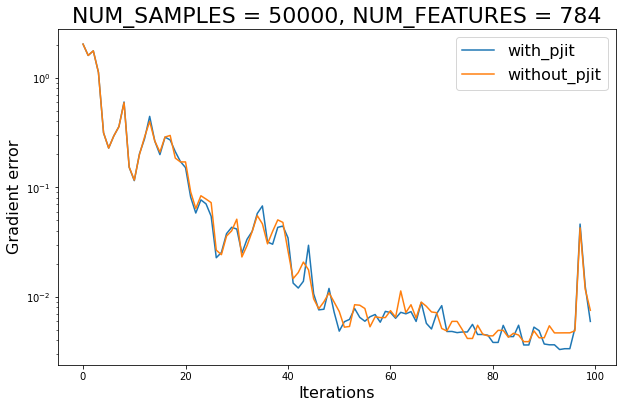

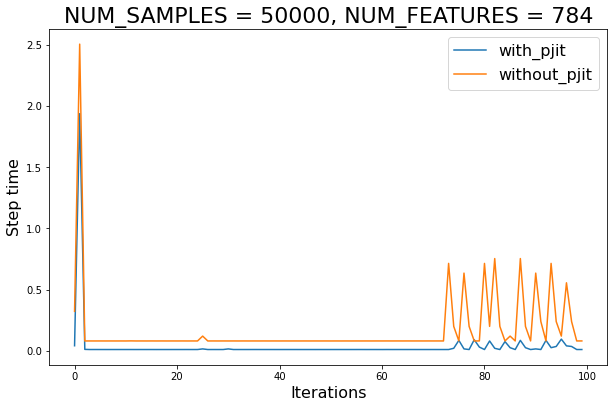

In [10]:
print("num_samples:", NUM_SAMPLES)
print("num_features:", NUM_FEATURES)
print("num_features:", NUM_CLASSES)
print("maxiter:", MAXITER)
print("stepsize:", STEPSIZE)
print("linesearch (ignored if `stepsize` > 0):", LINESEARCH)
print()

errors, step_times, compile_time = run()
print('Average speed-up (ignoring compile):',
      round((step_times['without_pjit'] / step_times['with_pjit']).mean(), 2))